In [1]:
import pandas as pd
import numpy as np
import ast
import sys
import warnings 
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
from datetime import timedelta, datetime
import plotly.graph_objs as go


In [41]:
# Re-running the code including all the steps from generating the datetime range to creating the DataFrame

# Number of rows
n_rows = 2000

# Generate a datetime range
date_range = pd.date_range(start='2023-01-01', periods=n_rows, freq='T')
date_range = date_range + pd.to_timedelta(np.random.randint(0, 60, size=n_rows), unit='s')

# Convert to a list to allow shuffling
date_list = date_range.to_list()
np.random.shuffle(date_list)

# Generate random States
states = np.random.choice(['A', 'B', 'C'], size=n_rows)

# Generate NormalizedPnlRate
normalized_pnl_rate = np.random.uniform(-100, 100, size=n_rows)

# Create the DataFrame
data = {
    'Time': date_list,
    'State': states,
    'NormalizedPnlRate': normalized_pnl_rate
}

df = pd.DataFrame(data)

# Sort by Time to have ascending order
df.sort_values(by='Time', inplace=True)

# Display the first few rows
df.head()

,Time,State,NormalizedPnlRate
1996,2023-01-01 00:00:26,C,97.033765
1950,2023-01-01 00:01:07,C,20.850285
1489,2023-01-01 00:02:32,C,-68.342347
886,2023-01-01 00:03:13,B,44.829740
1221,2023-01-01 00:04:56,A,75.503119


In [42]:
df = df.set_index('Time')
df

,State,NormalizedPnlRate
Time,,
2023-01-01 00:00:26,C,97.033765
2023-01-01 00:01:07,C,20.850285
2023-01-01 00:02:32,C,-68.342347
2023-01-01 00:03:13,B,44.829740
2023-01-01 00:04:56,A,75.503119
...,...,...
2023-01-02 09:15:40,B,18.751531
2023-01-02 09:16:22,B,-68.395216
2023-01-02 09:17:42,A,-60.254009


In [43]:
def remove_outliers(df, column_name):
    """
    Remove outliers from a DataFrame for all states based on specified column using IQR method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Column name containing data to filter.

    Returns:
    - dict: Dictionary containing filtered Series for each state.
    """
    removed_outliers = {}
    
    # Iterate through unique states
    for state in df['State'].unique():
        df_state = df[df['State'] == state][column_name]
        Q1 = df_state.quantile(0.25)
        Q3 = df_state.quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df_state[~((df_state < (Q1 - 1.5 * IQR)) | (df_state > (Q3 + 1.5 * IQR)))]
        removed_outliers[state] = df_filtered
    
    return removed_outliers

Normalized PnL for State: C
count    697.000000
mean       3.814747
std       57.414720
min      -99.709331
25%      -46.569461
50%        4.167988
75%       54.561241
max       99.989157
Name: NormalizedPnlRate, dtype: float64
P-value: 8.180365022522618e-14
Sample does not look Gaussian (reject H0)


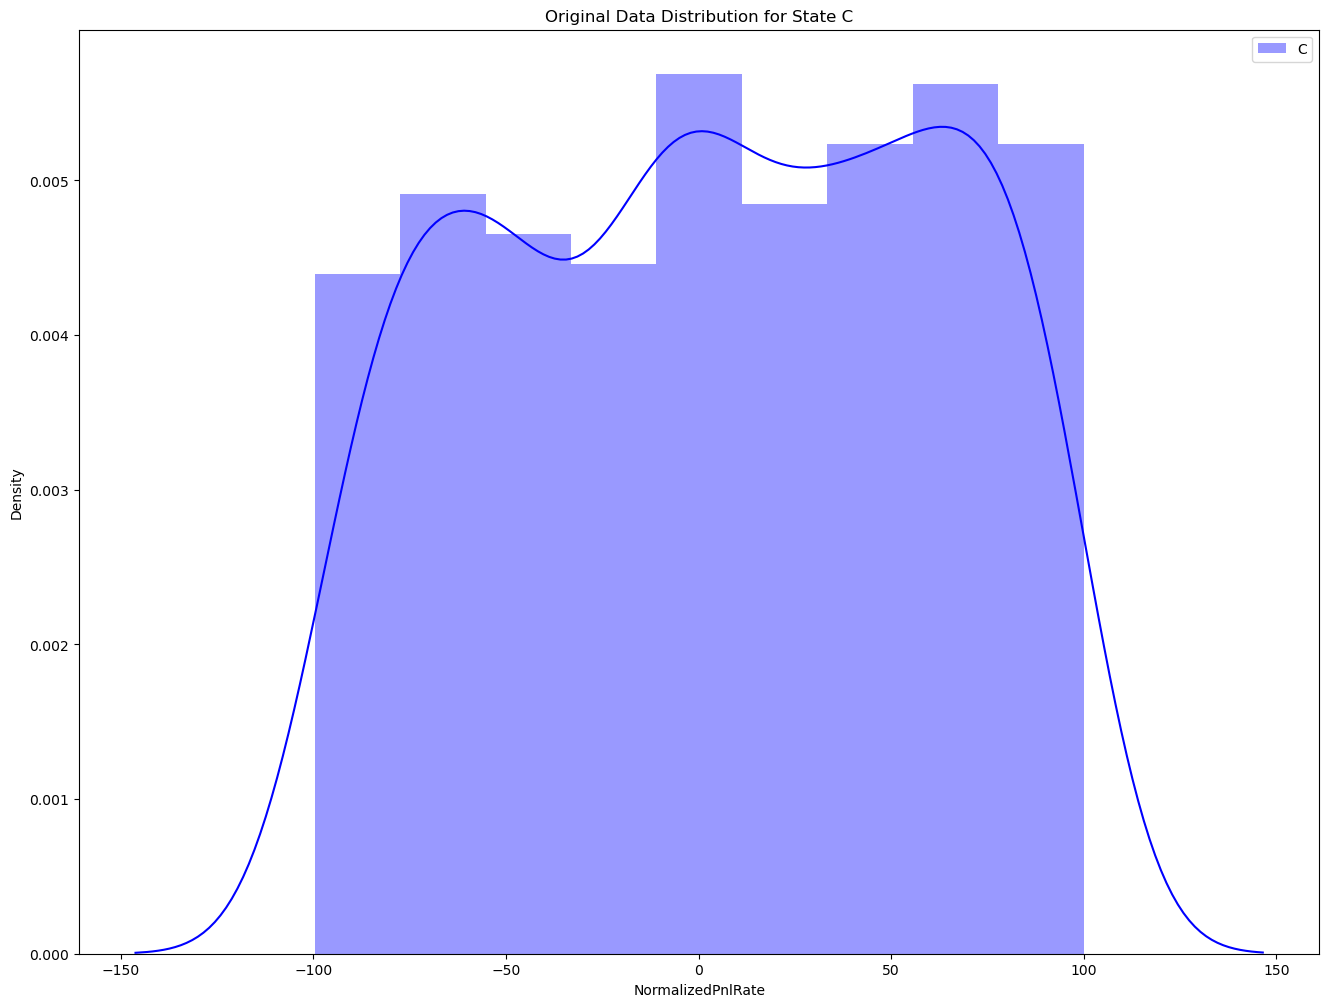

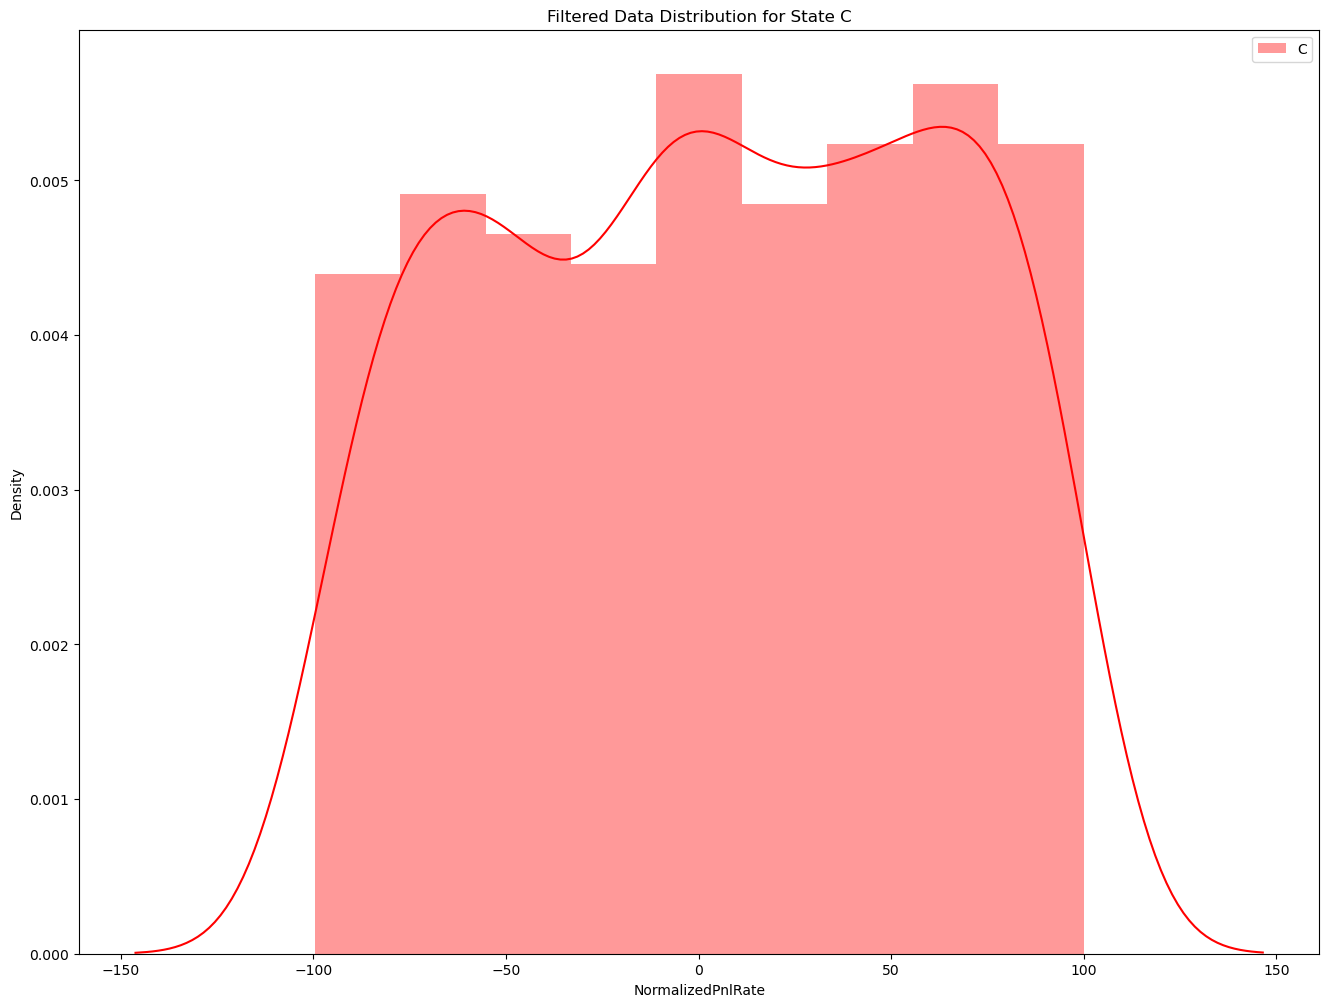

Normalized PnL for State: B
count    662.000000
mean      -2.885860
std       58.043696
min      -99.660669
25%      -53.374410
50%       -3.976750
75%       47.359576
max       99.477791
Name: NormalizedPnlRate, dtype: float64
P-value: 2.1348393430646595e-13
Sample does not look Gaussian (reject H0)


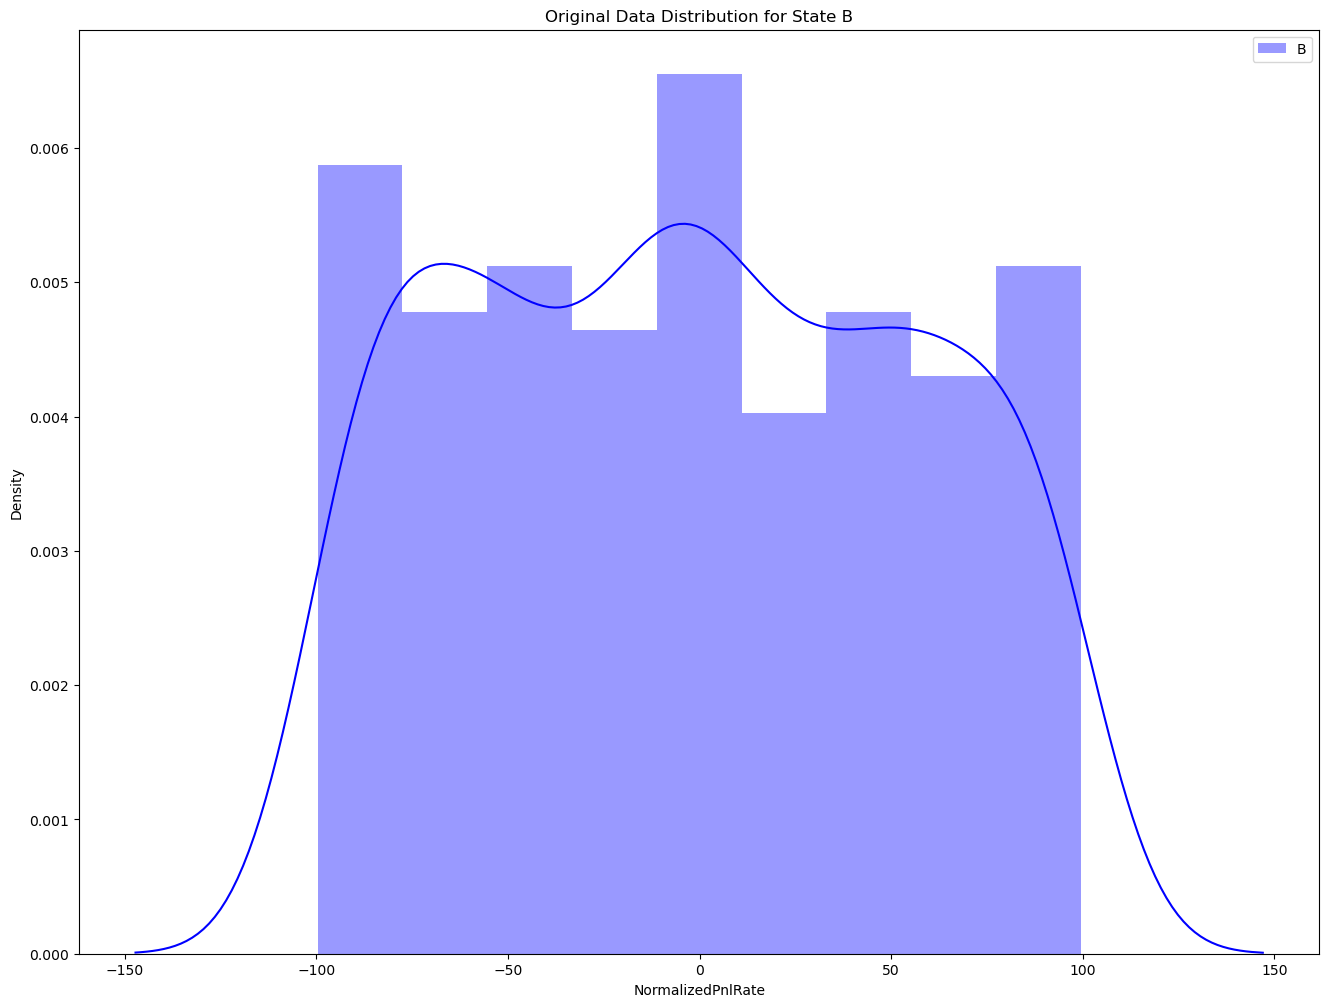

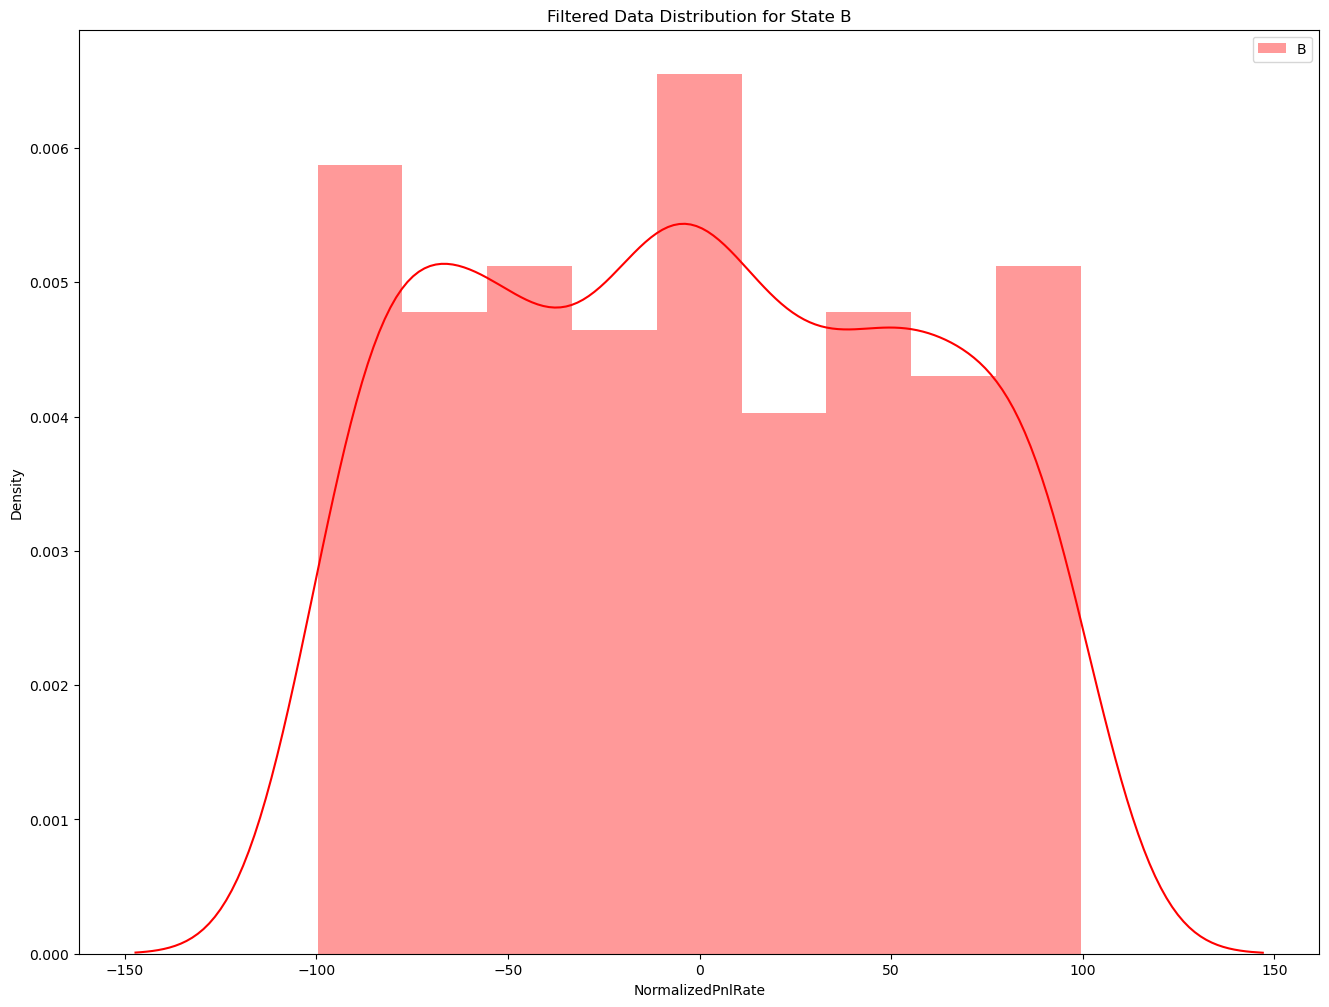

Normalized PnL for State: A
count    641.000000
mean       2.133934
std       57.237680
min      -99.648298
25%      -45.885993
50%        5.949618
75%       49.509859
max       99.541315
Name: NormalizedPnlRate, dtype: float64
P-value: 5.726059817273699e-13
Sample does not look Gaussian (reject H0)


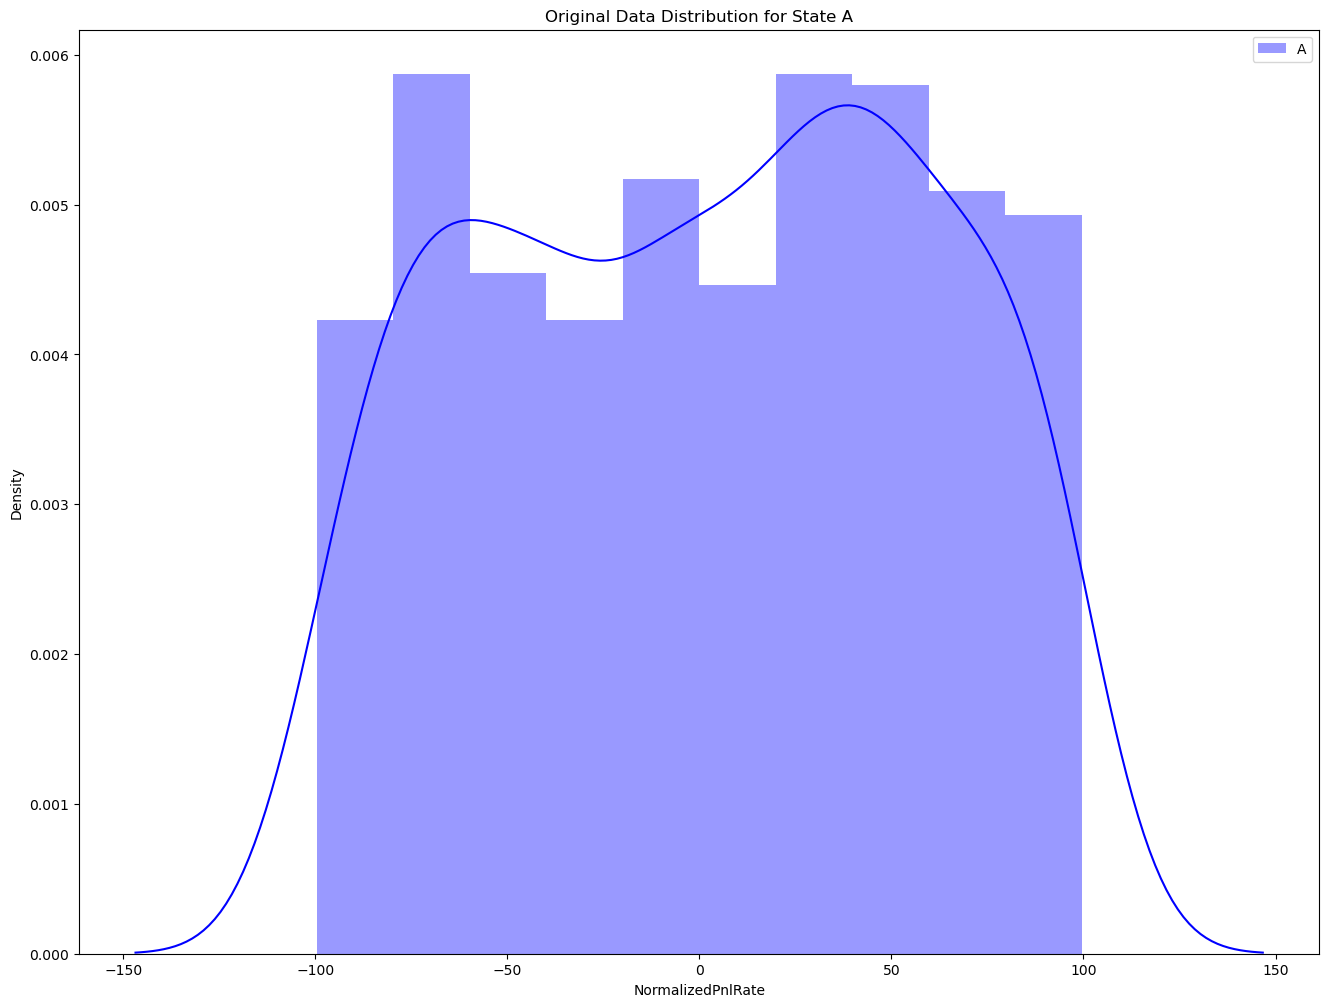

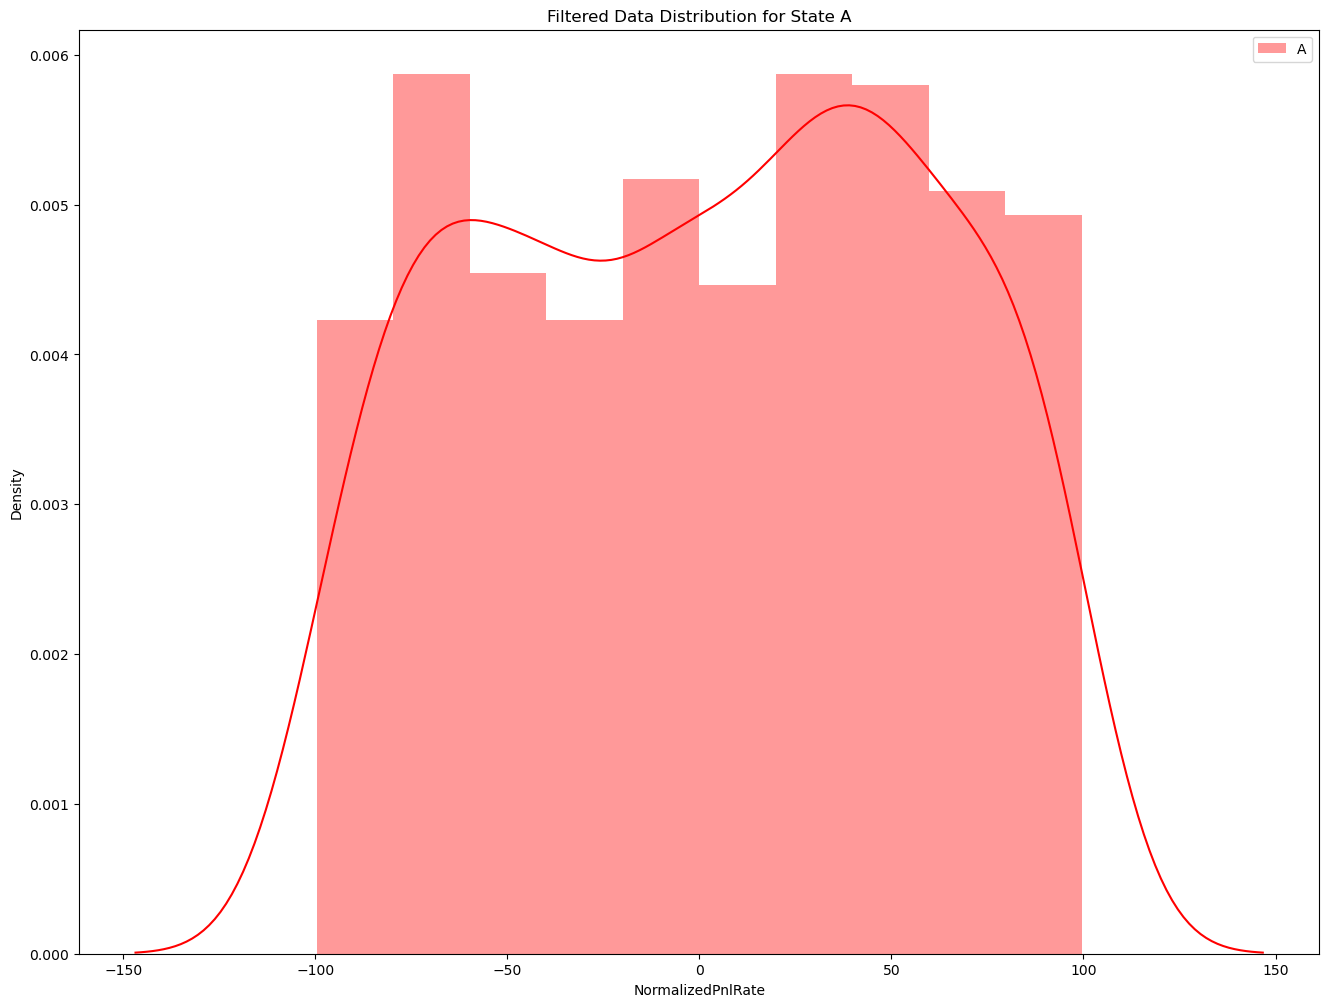

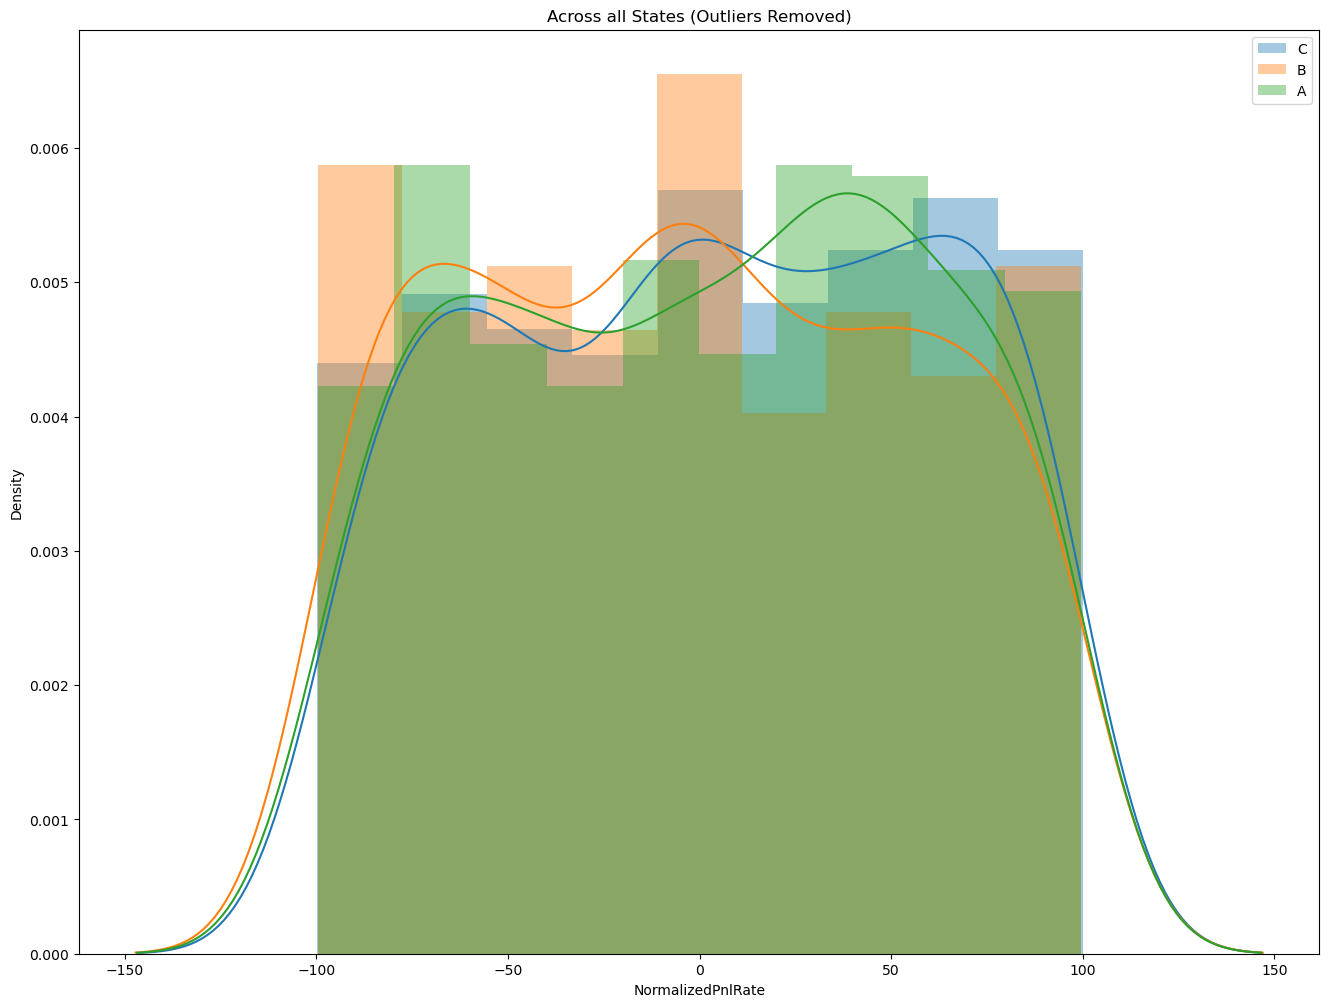

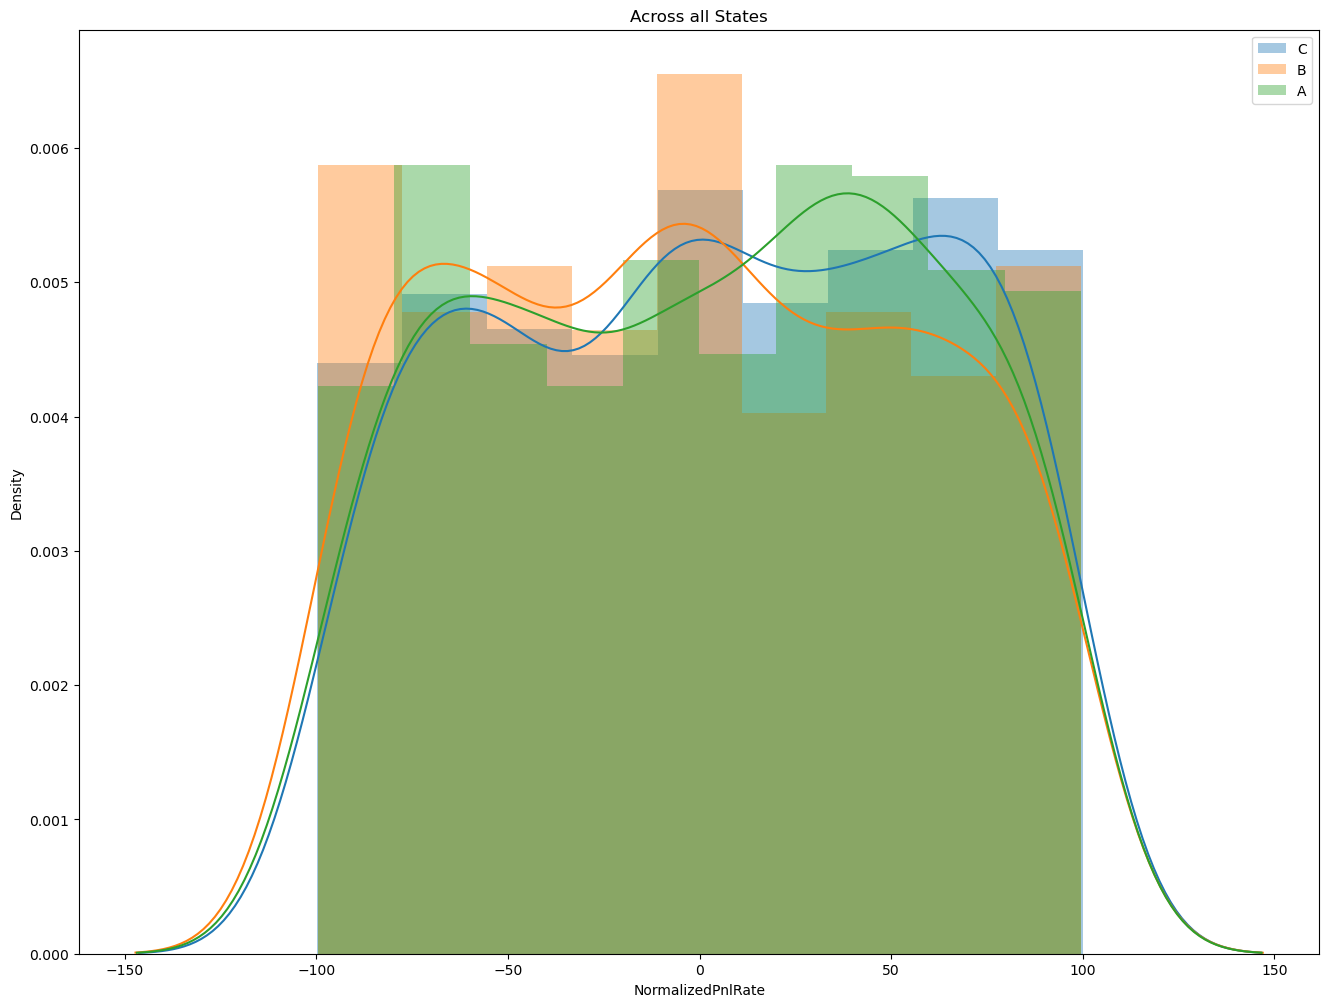

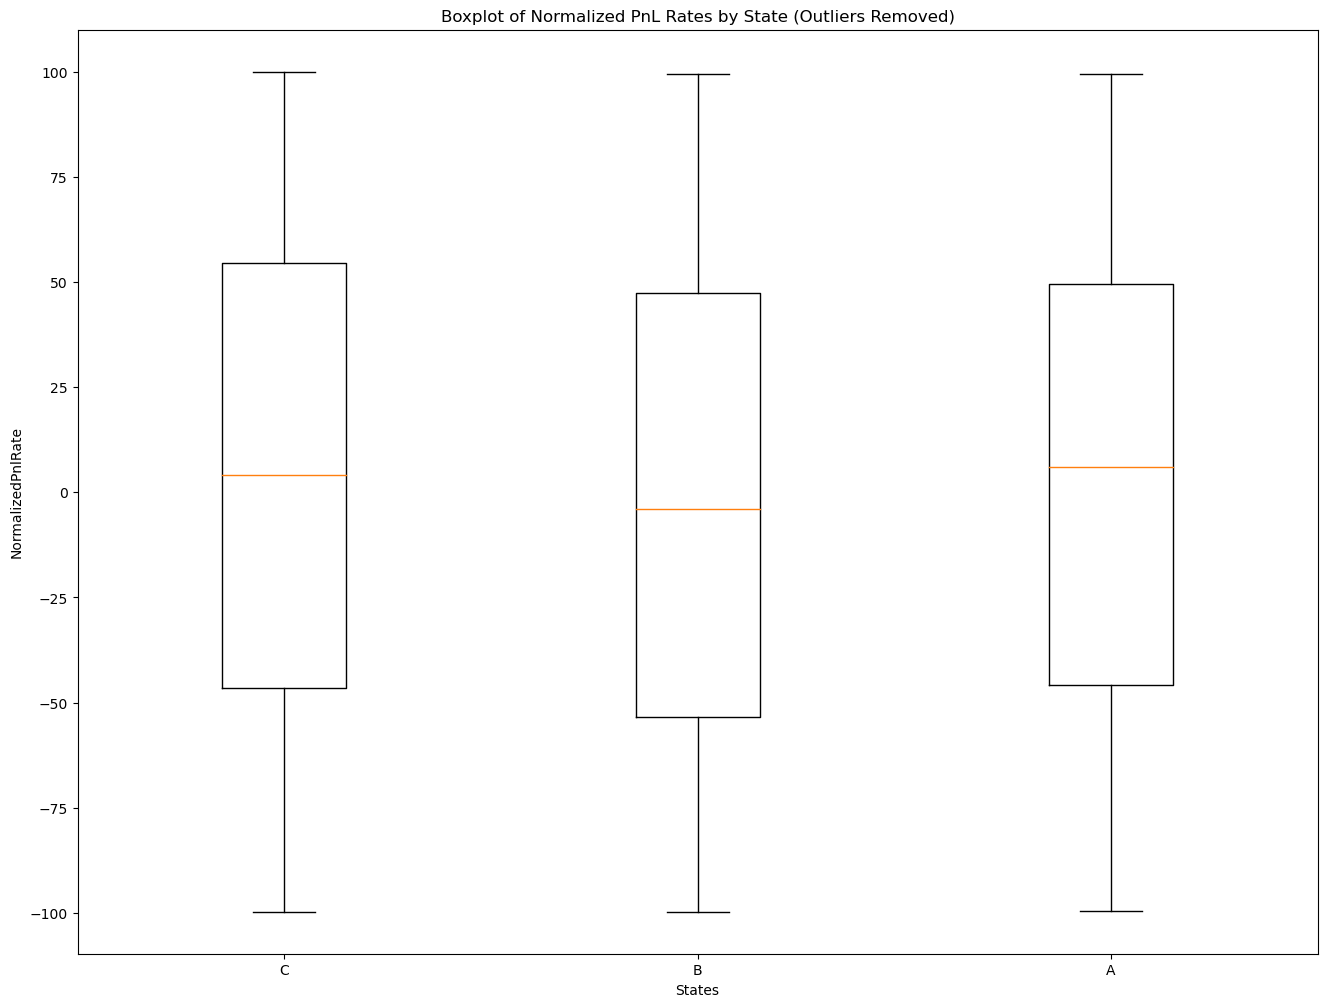

In [44]:
import scipy
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def analyze_normalized_pnl(df, column_name='NormalizedPnlRate'):
    states_list = df['State'].unique()
    removed_outliers = {}

    for state in states_list:
        df_state = df[df['State'] == state][column_name]
        Q1 = df_state.quantile(0.25)
        Q3 = df_state.quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df_state[~((df_state < (Q1 - 1.5 * IQR)) | (df_state > (Q3 + 1.5 * IQR)))]
        removed_outliers[state] = df_filtered

        print('==================================================================')
        print('Normalized PnL for State:', state)
        print(df_state.describe())
        print('==================================================================')

        stat, p = shapiro(df_filtered)
        alpha = 0.05
        if p > alpha:
            print('P-value:', p)
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('P-value:', p)
            print('Sample does not look Gaussian (reject H0)')

        sns.distplot(df_state, color="blue", label=state)
        plt.title(f'Original Data Distribution for State {state}')
        plt.legend()
        plt.show()

        sns.distplot(df_filtered, color="red", label=state)
        plt.title(f'Filtered Data Distribution for State {state}')
        plt.legend()
        plt.show()

    plt.title('Across all States (Outliers Removed)')
    for state in states_list:
        sns.distplot(removed_outliers[state], label=state)
    plt.legend()
    plt.show()

    plt.title('Across all States')
    for state in states_list:
        sns.distplot(df[df['State'] == state][column_name], label=state)
    plt.legend()
    plt.show()

    positions = range(1, len(states_list) + 1)
    plt.boxplot([removed_outliers[state] for state in states_list], positions=positions)
    plt.xticks(positions, states_list)
    plt.xlabel('States')
    plt.ylabel(column_name)
    plt.title('Boxplot of Normalized PnL Rates by State (Outliers Removed)')
    plt.show()

# Example usage with the generated DataFrame
analyze_normalized_pnl(df)


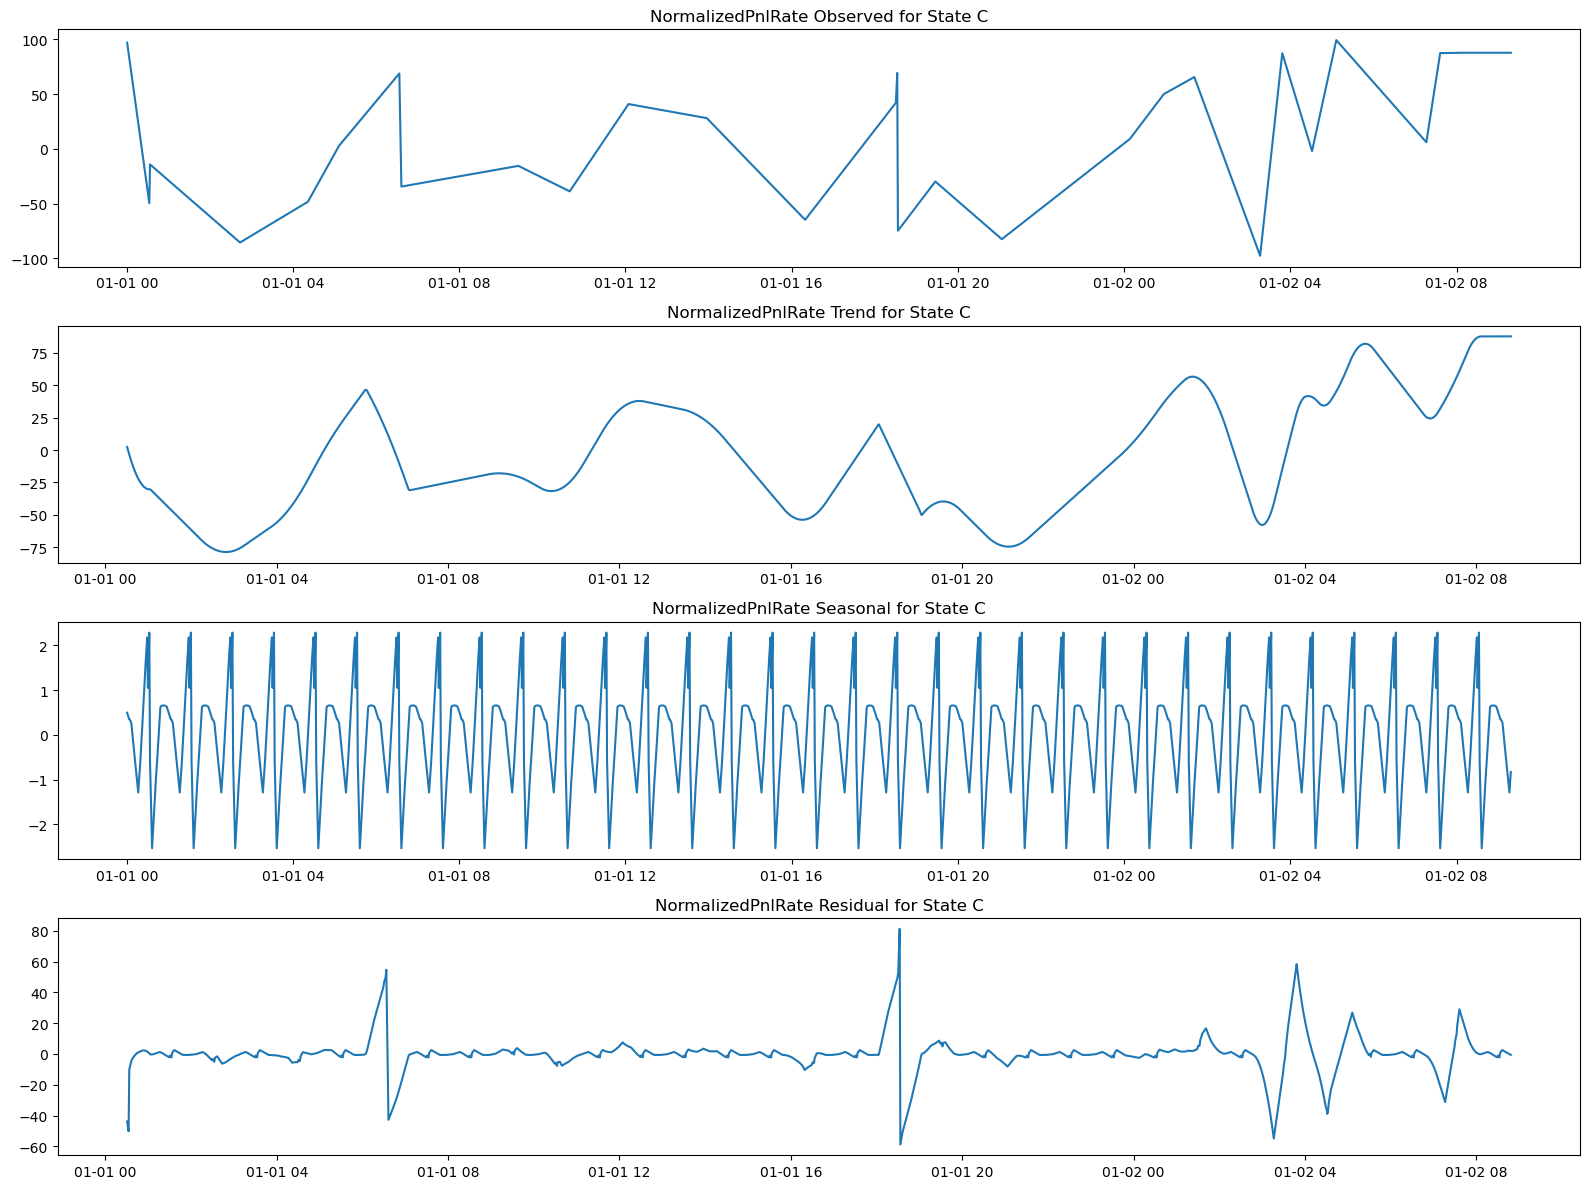

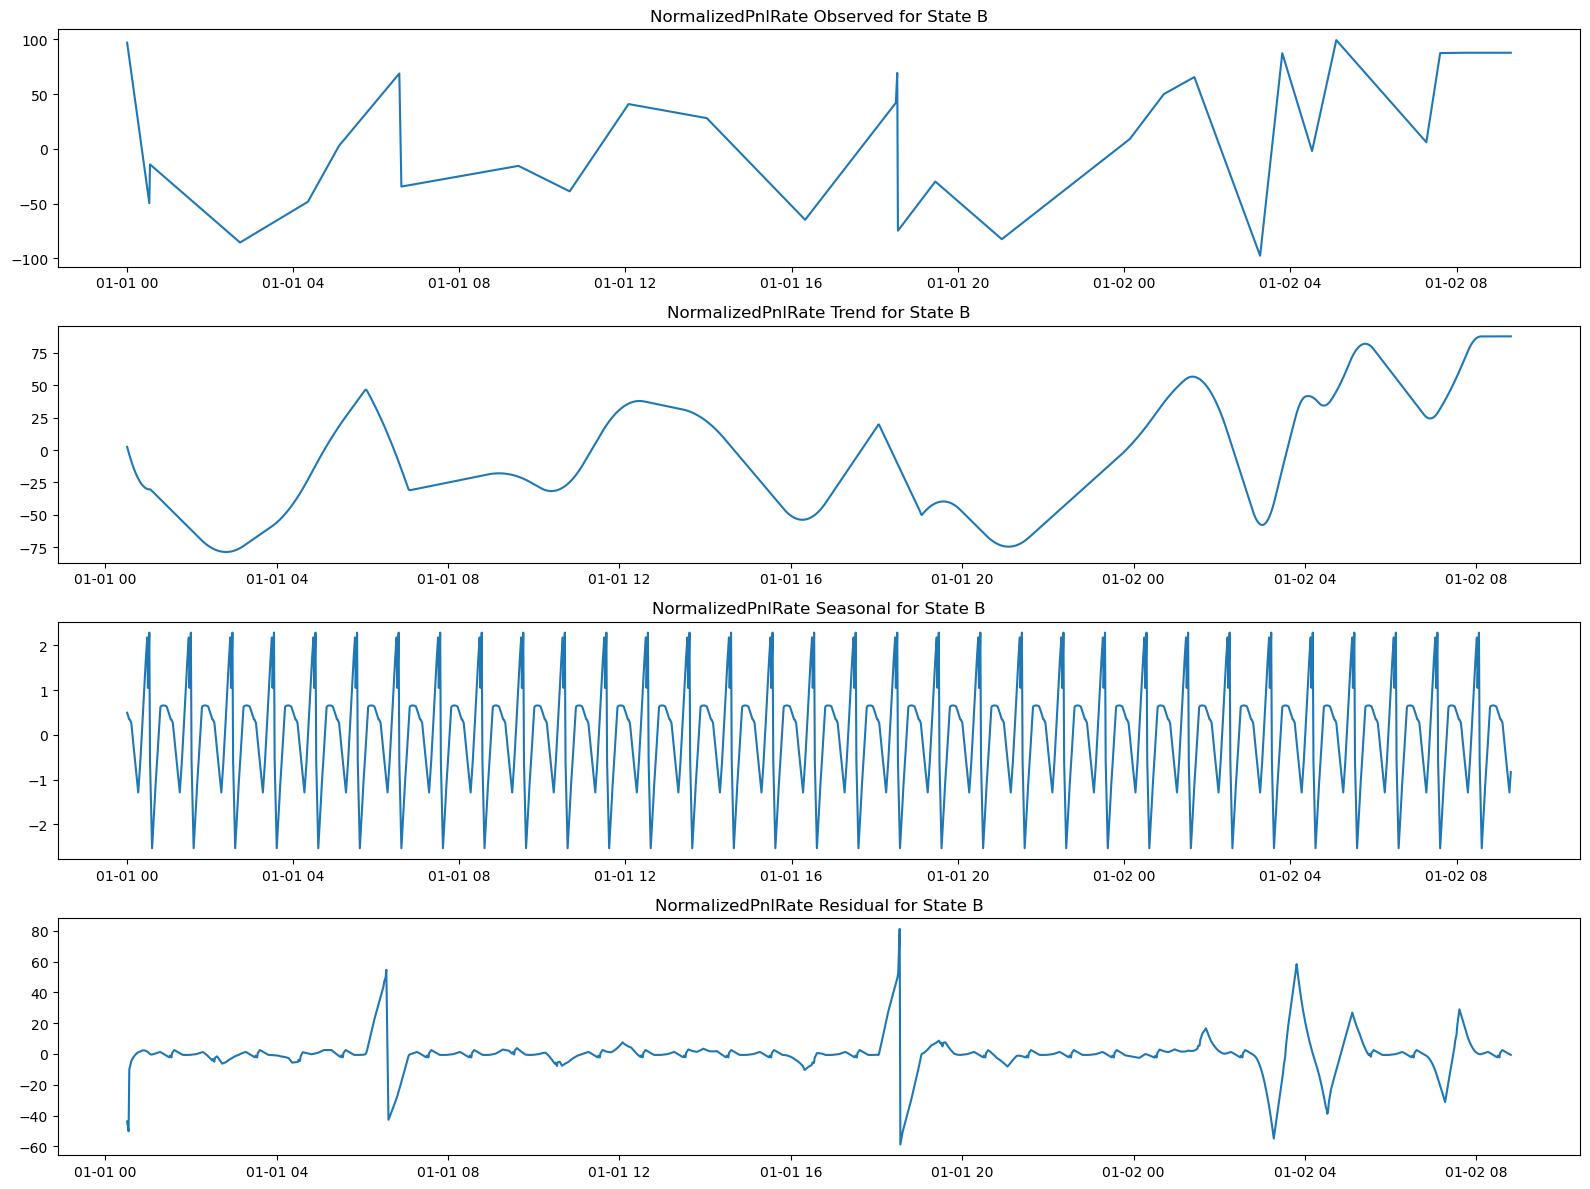

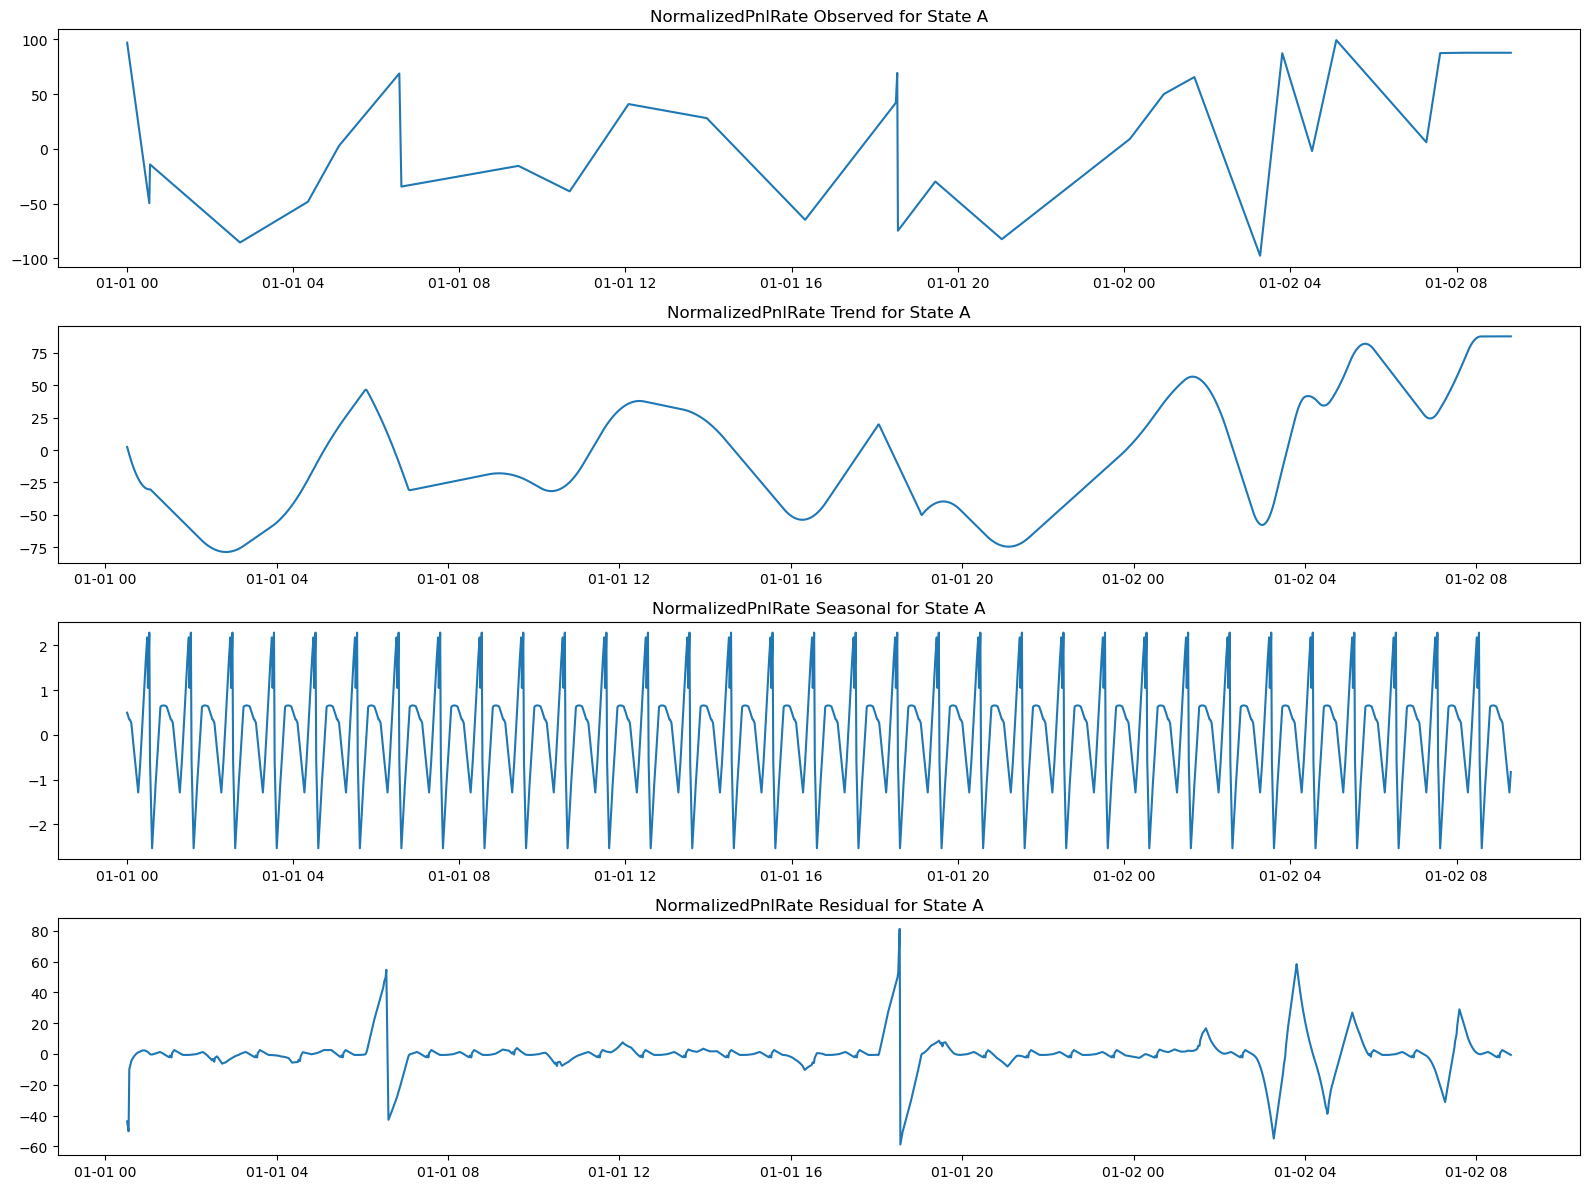

In [45]:
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

def seasonal_decompose_pnl(df, column_name='NormalizedPnlRate', freq='T', period=60):
    states_list = df['State'].unique()

    for state in states_list:
        df_state = df.asfreq(freq).interpolate(method='time')  # Ensure consistent frequency and interpolate missing values

        decomposition = sm.tsa.seasonal_decompose(df_state[column_name], model='additive', period=period)

        rcParams["figure.figsize"] = 16, 12

        plt.figure()
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title(f'{column_name} Observed for State {state}')

        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title(f'{column_name} Trend for State {state}')

        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title(f'{column_name} Seasonal for State {state}')

        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title(f'{column_name} Residual for State {state}')

        plt.tight_layout()
        plt.show()

# Example usage with the generated DataFrame
seasonal_decompose_pnl(df)


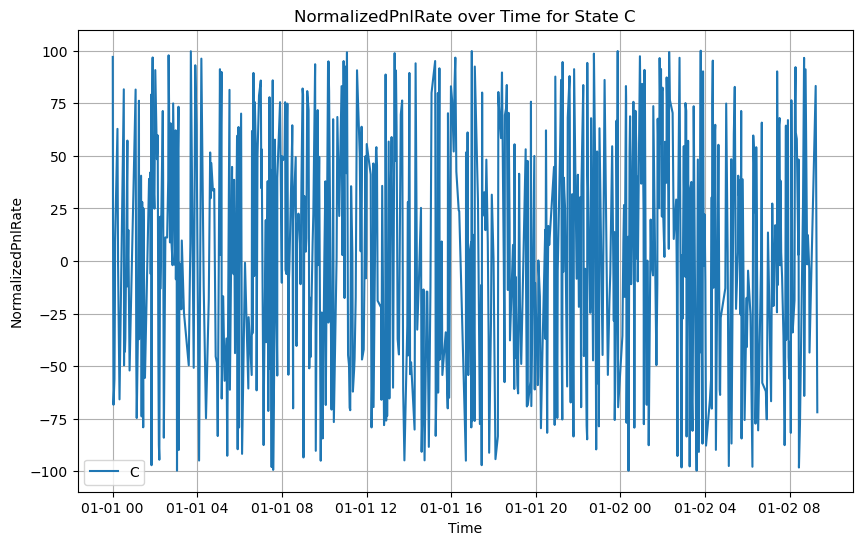

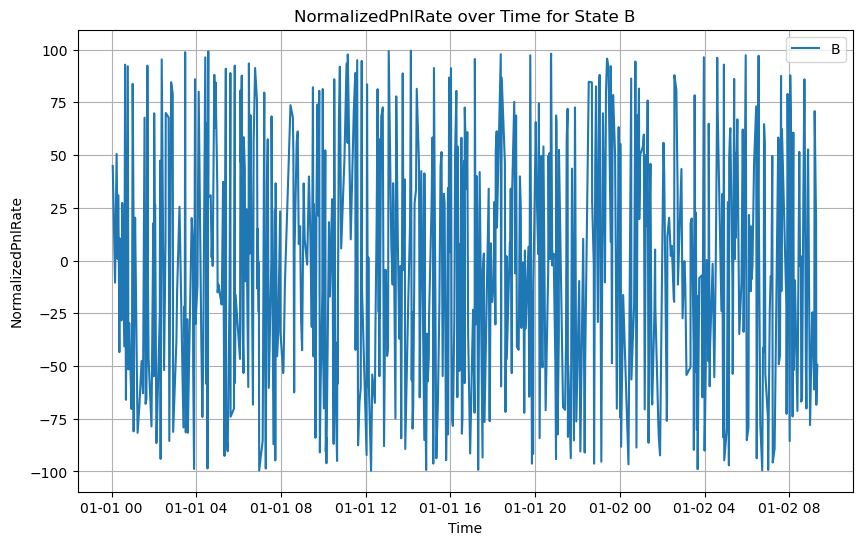

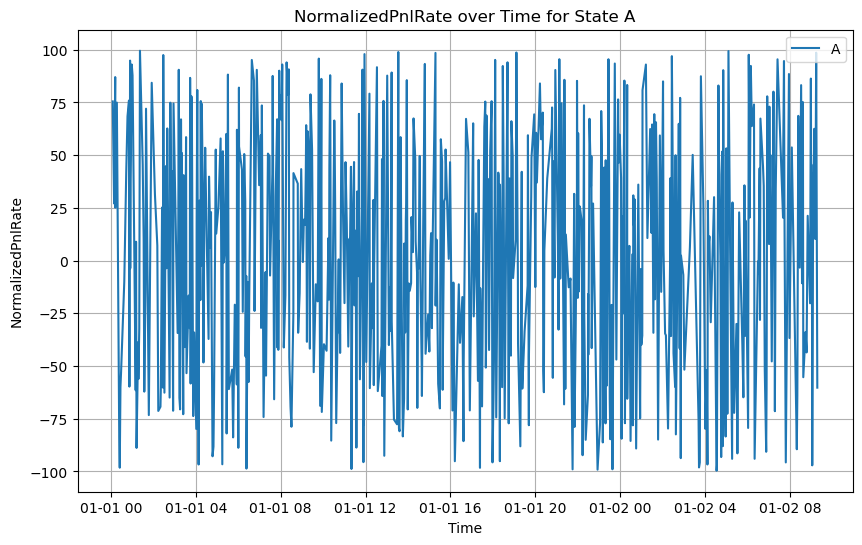

In [46]:
import matplotlib.pyplot as plt

def plot_time_series_per_state(df, column_name='NormalizedPnlRate'):
    states_list = df['State'].unique()

    for state in states_list:
        df_state = df[df['State'] == state]

        plt.figure(figsize=(10, 6))
        plt.plot(df_state[column_name], label=state)
        plt.xlabel('Time')
        plt.ylabel(column_name)
        plt.title(f'{column_name} over Time for State {state}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage with the generated DataFrame
plot_time_series_per_state(df)


In [47]:
state_proportions = df['State'].value_counts(normalize=True) * 100
print(state_proportions)

State
C    34.85
B    33.10
A    32.05
Name: proportion, dtype: float64


In [48]:
def subset_df_into_samples(df, sample_size=50):
    """
    Subsets the DataFrame into samples of a specified size.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    sample_size (int): The number of rows per sample (default is 50).
    
    Returns:
    list of DataFrames: A list containing the subset samples as DataFrames.
    """
    num_samples = len(df) // sample_size
    samples = [df.iloc[i*sample_size:(i+1)*sample_size] for i in range(num_samples)]
    
    # Handle remaining rows if any
    if len(df) % sample_size != 0:
        samples.append(df.iloc[num_samples*sample_size:])
    
    return samples

# Example usage with the generated DataFrame
samples = subset_df_into_samples(df)
print(f"Number of samples: {len(samples)}")
for i, sample in enumerate(samples):
    print(f"Sample {i+1} shape: {sample.shape}")
    print(sample.head())


Number of samples: 40
Sample 1 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:26     C          97.033765
2023-01-01 00:01:07     C          20.850285
2023-01-01 00:02:32     C         -68.342347
2023-01-01 00:03:13     B          44.829740
2023-01-01 00:04:56     A          75.503119
Sample 2 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:50:47     A          75.920008
2023-01-01 00:51:12     A           0.175827
2023-01-01 00:52:02     A         -59.750714
2023-01-01 00:53:56     A          94.855623
2023-01-01 00:54:24     A          -3.663902
Sample 3 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-01 01:40:54     B          -4.338588
2023-01-01 01:41:19     B          92.400342
2023-01-01 01:42:51     B          -7.499668
2023-01-01 01:43:24     C          39.052822
2023-0

In [49]:
def plot_means_boxplot(df, sample_size=50):
    """
    Calculates the means across each sample for each state and plots the means in a boxplot.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - sample_size (int): Size of each subset.

    Returns:
    - None (plots the boxplot).
    """
    # Subset the DataFrame
    subsets = subset_df_into_samples(df, sample_size)

    # Calculate means and std for each state across samples
    means = {state: [] for state in df['State'].unique()}
    stds = {state: [] for state in df['State'].unique()}
    for subset in subsets:
        state_means = subset.groupby('State')['NormalizedPnlRate'].mean()
        state_stds = subset.groupby('State')['NormalizedPnlRate'].std()
        for state, mean in state_means.items():
            means[state].append(mean)
            stds[state].append(state_stds[state])

    # Convert means and stds to list for plotting
    means_list = [means[state] for state in df['State'].unique()]
    stds_list = [stds[state] for state in df['State'].unique()]

    # Plotting
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(means_list, labels=df['State'].unique(), patch_artist=True)

    # Add mean and std labels to each box
    for i, state in enumerate(df['State'].unique()):
        y = means_list[i]
        x = np.random.normal(i + 1, 0.04, size=len(y))  # Adjust jitter for better visibility
        plt.scatter(x, y, color='black', s=10)
        plt.text(i + 1, np.mean(y), f'{np.mean(y):.2f}\n±{np.mean(stds_list[i]):.2f}',
                 horizontalalignment='center', verticalalignment='center', fontsize=10, color='white')

    plt.xlabel('State')
    plt.ylabel('Mean NormalizedPnlRate')
    plt.title(f'Mean NormalizedPnlRate across {sample_size}-row samples for each State')
    plt.show()


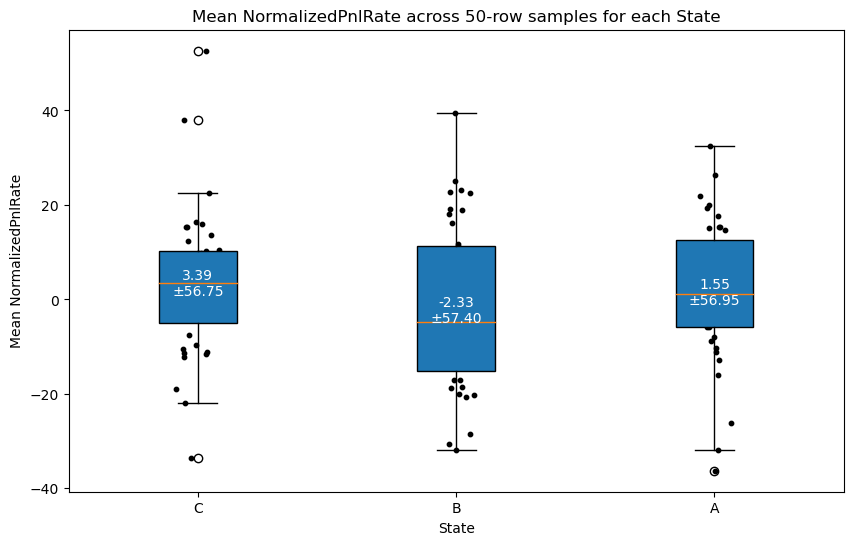

In [50]:
plot_means_boxplot(df, sample_size=50)

ANOVA Results:
F_onewayResult(statistic=2.4646737728142307, pvalue=0.08529521706236366)
F-statistic: 2.465
p-value: 8.530e-02
The ANOVA results do not show sufficient evidence to reject the null hypothesis.
There is no significant difference in NormalizedPnlRate across states based on the current data.


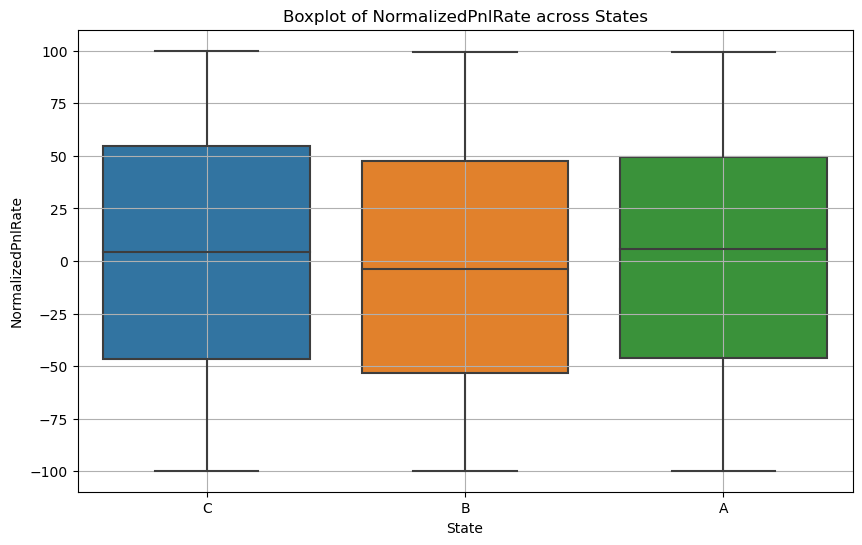

In [51]:
from scipy.stats import f_oneway

# Perform ANOVA
anova_result = f_oneway(
    df[df['State'] == 'A']['NormalizedPnlRate'],
    df[df['State'] == 'B']['NormalizedPnlRate'],
    df[df['State'] == 'C']['NormalizedPnlRate']
)

print("ANOVA Results:")
print(anova_result)
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue:.3e}")
# Interpretation and Conclusion
if anova_result.pvalue < 0.05:
    print("The ANOVA results indicate a statistically significant difference in NormalizedPnlRate across states.")
    print("Further analysis or post-hoc tests should be conducted to determine specific pairwise differences.")

else:
    print("The ANOVA results do not show sufficient evidence to reject the null hypothesis.")
    print("There is no significant difference in NormalizedPnlRate across states based on the current data.")

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='NormalizedPnlRate', data=df)
plt.xlabel('State')
plt.ylabel('NormalizedPnlRate')
plt.title('Boxplot of NormalizedPnlRate across States')
plt.grid(True)
plt.show()

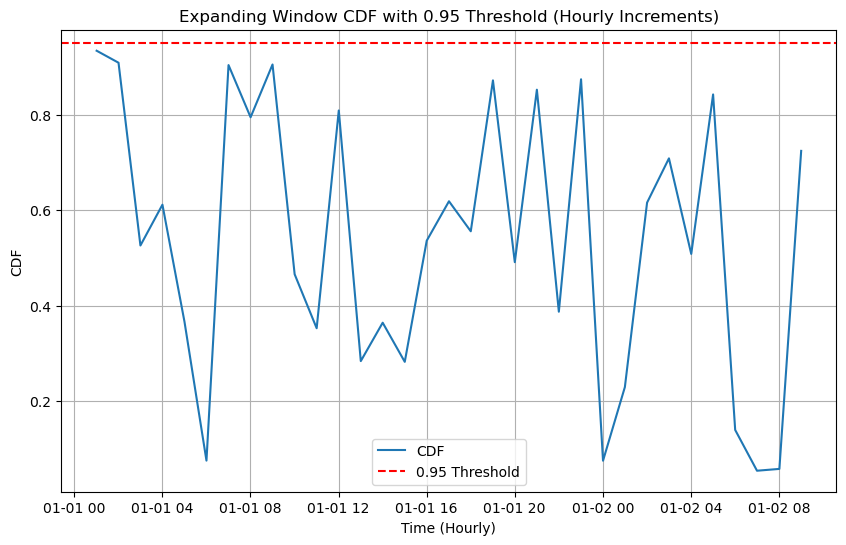

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate expanding window Z-score by specified time intervals
def expanding_zscore(data, interval='hour'):
    """
    Calculate expanding window Z-score based on specified time intervals.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with datetime index and 'NormalizedPnlRate' column.
    - interval (str): Interval for accumulation ('minute', 'hour', 'day').

    Returns:
    - result_df (pd.DataFrame): DataFrame with 'Time' as index and 'Z-score', 'CDF' columns.
    """
    # Initialize lists to store results
    z_scores = []
    time_intervals = []

    # Track accumulated data
    accumulated_data = []

    # Track start time and first interval
    start_time = data.index[0]
    current_interval = start_time

    for index, row in data.iterrows():
        if interval == 'min':
            current_index = index.minute
        elif interval == 'hour':
            current_index = index.hour
        elif interval == 'day':
            current_index = index.date()

        # Check if interval has changed
        if current_index != current_interval:
            if accumulated_data:
                # Calculate mean and std for accumulated data
                mean = np.mean(accumulated_data)
                std = np.std(accumulated_data)

                # Calculate Z-score for accumulated data
                z_score = (row['NormalizedPnlRate'] - mean) / std
                z_scores.append(z_score)
                time_intervals.append(index)

                # Reset accumulated data for next interval
                accumulated_data = []

            # Update current interval
            current_interval = current_index

        # Accumulate data for current interval
        accumulated_data.append(row['NormalizedPnlRate'])

    # Convert lists to DataFrame
    result_df = pd.DataFrame({'Time': time_intervals, 'Z-score': z_scores})
    result_df.set_index('Time', inplace=True)

    return result_df

# Example usage:
# Assuming df is your original DataFrame with datetime index and 'NormalizedPnlRate' column
# Calculate expanding window Z-score by hourly intervals
interval = 'hour'
df_zscores = expanding_zscore(df, interval)

# Function to calculate CDF
def calculate_cdf(z_score):
    return norm.cdf(z_score)

# Calculate CDF for Z-score
df_zscores['CDF'] = df_zscores['Z-score'].apply(calculate_cdf)

# Plot CDF with a horizontal line at 0.95
plt.figure(figsize=(10, 6))
plt.plot(df_zscores.index, df_zscores['CDF'], label='CDF')
plt.axhline(y=0.95, color='r', linestyle='--', label='0.95 Threshold')
plt.xlabel(f'Time ({interval.capitalize()}ly)')
plt.ylabel('CDF')
plt.title(f'Expanding Window CDF with 0.95 Threshold ({interval.capitalize()}ly Increments)')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
def subset_df_into_samples(df, interval='hour'):
    """
    Subsets the DataFrame into samples based on specified time intervals.

    Parameters:
    - df (DataFrame): The input DataFrame with datetime index.
    - interval (str): Interval for subsetting ('hour', '2H', 'day', etc.).

    Returns:
    - list of DataFrames: A list containing the subset samples as DataFrames.
    """
    if interval == 'hour':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='H'))]
    elif interval == '2H':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='2H'))]
    elif interval == 'day':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='D'))]
    # Add more intervals as needed (e.g., 'W' for weekly)

    return samples

# Subset into samples by hour, 2 hours, and day
hourly_samples = subset_df_into_samples(df, interval='hour')
two_hourly_samples = subset_df_into_samples(df, interval='2H')
daily_samples = subset_df_into_samples(df, interval='day')

# Example printout of sample sizes
print(f"Hourly samples: {len(hourly_samples)}")
print(f"Two-hourly samples: {len(two_hourly_samples)}")
print(f"Daily samples: {len(daily_samples)}")

# Example printout of the first sample for each interval
print("\nFirst sample for each interval:")
print("Hourly sample:")
print(hourly_samples[0].head())
print("\nTwo-hourly sample:")
print(two_hourly_samples[0].head())
print("\nDaily sample:")
print(daily_samples[0].head())

Hourly samples: 34
Two-hourly samples: 17
Daily samples: 2

First sample for each interval:
Hourly sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:26     C          97.033765
2023-01-01 00:01:07     C          20.850285
2023-01-01 00:02:32     C         -68.342347
2023-01-01 00:03:13     B          44.829740
2023-01-01 00:04:56     A          75.503119

Two-hourly sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:26     C          97.033765
2023-01-01 00:01:07     C          20.850285
2023-01-01 00:02:32     C         -68.342347
2023-01-01 00:03:13     B          44.829740
2023-01-01 00:04:56     A          75.503119

Daily sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:26     C          97.033765
2023-01-01 00:01:07     C          20.850285
2023-01-01 00:02:32     C         -68.342347
202

In [60]:
# from scipy.stats import ttest_ind

# # Subset data for State A and State B
# df_state_A = df[df['State'] == 'A'].copy()
# df_state_B = df[df['State'] == 'B'].copy()

# # Initialize lists to store p-values and observation counts
# p_values = []
# observation_counts = []

# # Loop through each observation in State A
# for index_A, row_A in df_state_A.iterrows():
#     # Find the nearest index in State B based on time
#     closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
#     index_B = df_state_B.index.get_loc(closest_index_B)

#     # Subset data up to the current observation for both states
#     data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
#     data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
#     # Perform t-test (assuming equal variances for simplicity)
#     t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=True)
    
#     # Append p-value and observation count
#     p_values.append(p_value)
#     observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0

# # Plotting cumulative p-values
# plt.figure(figsize=(10, 6))
# plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b')
# plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
# plt.xlabel('Observation Number')
# plt.ylabel('P-value')
# plt.title('Continuous Hypothesis Testing: State A vs State B')
# plt.legend()
# plt.grid(True)
# plt.show()

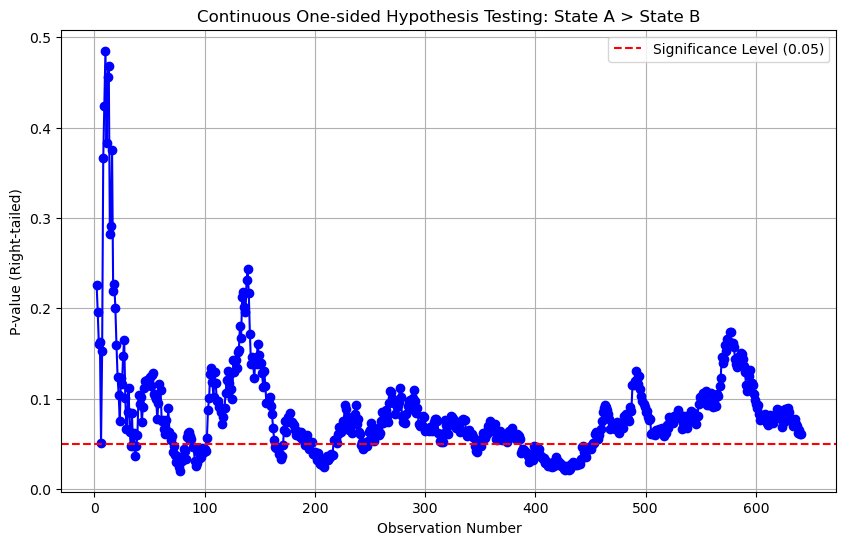

In [70]:
from scipy.stats import ttest_ind

# Subset data for State A and State B
df_state_A = df[df['State'] == 'A'].copy()
df_state_B = df[df['State'] == 'B'].copy()

# Initialize lists to store p-values and observation counts
p_values = []
observation_counts = []

# Loop through each observation in State A
for index_A, row_A in df_state_A.iterrows():
    # Find the nearest index in State B based on time
    closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
    index_B = df_state_B.index.get_loc(closest_index_B)

    # Subset data up to the current observation for both states
    data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
    data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
    # Perform one-sided t-test (right-tailed)
    t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=False)
    
    # Store p-value for right-tailed test (p_value / 2 < alpha and t_stat > 0)
    p_values.append(p_value / 2)  # Dividing p-value by 2 for one-sided test
    observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0

# Plotting cumulative p-values
plt.figure(figsize=(10, 6))
plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Observation Number')
plt.ylabel('P-value (Right-tailed)')
plt.title('Continuous One-sided Hypothesis Testing: State A > State B')
plt.legend()
plt.grid(True)
plt.show()

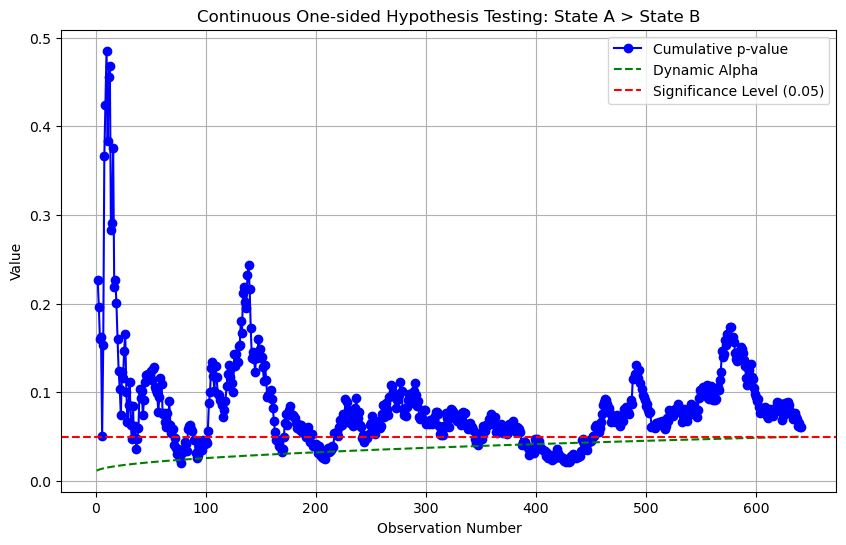

In [76]:
# Subset data for State A and State B
df_state_A = df[df['State'] == 'A'].copy()
df_state_B = df[df['State'] == 'B'].copy()

# Initialize lists to store p-values, observation counts, and alpha values
p_values = []
observation_counts = []
alpha_values = []

# Function to calculate dynamic significance level
def dynamic_significance_level(observation_count):
    initial_alpha = 0.01  # Initial very low significance level
    final_alpha = 0.05    # Final significance level
    
    # Square root decrease from initial_alpha to final_alpha over time
    alpha = initial_alpha - (initial_alpha - final_alpha) * (np.sqrt(observation_count) / np.sqrt(len(df_state_A)))
    
    return alpha

# Loop through each observation in State A
for index_A, row_A in df_state_A.iterrows():
    # Find the nearest index in State B based on time
    closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
    index_B = df_state_B.index.get_loc(closest_index_B)

    # Subset data up to the current observation for both states
    data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
    data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
    # Perform one-sided t-test (right-tailed)
    t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=False)
    
    # Calculate dynamic significance level
    alpha = dynamic_significance_level(len(p_values) + 1)
    alpha_values.append(alpha)
    
    # Store p-value for right-tailed test (p_value / 2 < alpha and t_stat > 0)
    p_values.append(p_value / 2)  # Dividing p-value by 2 for one-sided test
    observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0


# Plotting cumulative p-values with dynamic significance level and alpha values
plt.figure(figsize=(10, 6))
plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b', label='Cumulative p-value')
plt.plot(observation_counts, alpha_values, linestyle='--', color='g', label='Dynamic Alpha')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Observation Number')
plt.ylabel('Value')
plt.title('Continuous One-sided Hypothesis Testing: State A > State B')
plt.legend()
plt.grid(True)
plt.show()